In [1]:
pretty = True
highres = True

%matplotlib inline
if highres:
    %config InlineBackend.figure_format = 'retina'
else:
    %config InlineBackend.figure_format = 'png'

#rcParams["figure.dpi"]=300

import sys
from pathlib import Path

pypsapath = "C:/dev/py/PyPSA/"

if sys.path[0] != pypsapath:
    sys.path.insert(0,pypsapath)

if Path("../..") not in [Path(p) for p in sys.path]:
    sys.path.insert(0,"../..")

%load_ext autoreload
%autoreload 2

In [18]:
import src.globals
from src.scigridnetwork import SciGRID_network
from src.armafitloader import ARMAfit_loader
import src.plothelper

In [3]:
import pypsa
import numpy as np
import pandas as pd
import os
import itertools
import scipy.stats

import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib.dates
import matplotlib.font_manager
from matplotlib import rcParams

rcParams["font.family"] = "sans-serif"


from IPython.display import Markdown, display
printm = lambda s: display(Markdown(s))

In [8]:
sgn = SciGRID_network()
fav_sgn = sgn

Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.



0.13.2 ['C:/dev/py/PyPSA\\pypsa']


In [20]:
month_index = 0
month_name = ARMAfit_loader.monthnames[month_index]

solar_diff_cov = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "solar_diffdaylightcov.npy")
wind_diff_cov = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "wind_diffcov.npy")
solar_diff_cov_norm = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "solar_diffdaylightcovnorm.npy")
wind_diff_cov_norm = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "wind_diffcovnorm.npy")

In [21]:
bus_diff_cov_day = wind_diff_cov + solar_diff_cov
bus_diff_cov_night = wind_diff_cov
bus_diff_cov_day_norm = wind_diff_cov_norm + solar_diff_cov_norm
bus_diff_cov_night_norm = wind_diff_cov_norm

In [22]:
line_diff_cov_day = sgn.F @ bus_diff_cov_day @ sgn.F.T
line_diff_cov_night = sgn.F @ bus_diff_cov_night @ sgn.F.T
line_diff_cov_day_norm = sgn.F @ bus_diff_cov_day_norm @ sgn.F.T
line_diff_cov_night_norm = sgn.F @ bus_diff_cov_night_norm @ sgn.F.T

In [12]:
sgn.run_lopf_jan1()

Performing linear OPF for one day, 4 snapshots at a time:


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:48<00:00,  8.42s/it]


In [14]:
ratings = sgn.get_line_ratings(bus_diff_cov_day)

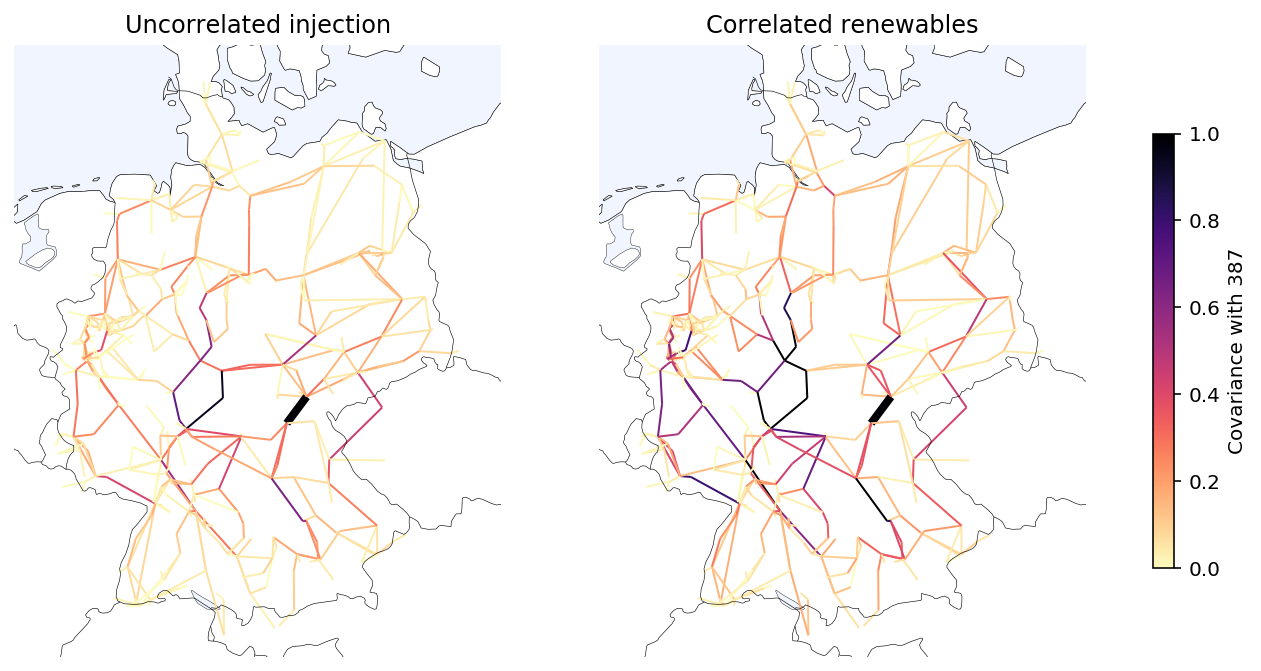

In [84]:
fig = plt.figure(figsize=(12,8))
import cartopy.crs as ccrs 
ax = fig.subplots(1,2,subplot_kw={"projection":ccrs.TransverseMercator(central_longitude=10.0, central_latitude=50.0)}).flatten()

geomap = "50m"

firstLine = 387

line_iid_cov = sgn.F @ sgn.F.T

# --

widths = np.ones(sgn.m)
widths[firstLine] = 4

line_colors, line_widths = fav_sgn.line_array_to_plot(np.abs(line_iid_cov[firstLine] / line_iid_cov[firstLine, firstLine]), widths)
# bus_sizes, bus_colors = fav_sgn.bus_array_to_plot(fav_sgn.injection_total.loc[elevenAM])
bus_sizes, bus_colors = fav_sgn.bus_array_to_plot()

pathcol, linecol = fav_sgn.network.plot(geomap=geomap, bus_sizes=bus_sizes, bus_colors=bus_colors, line_colors=line_colors, line_widths=line_widths, line_cmap="magma_r", ax=ax[0])
#cbar = fig.colorbar(linecol, ax=ax[0], shrink=.5)
#cbar.set_label(f"Covariance with {firstLine}")
ax[0].set_title("Uncorrelated injection")


# --

line_colors, line_widths = fav_sgn.line_array_to_plot(np.abs(line_diff_cov_day_norm[firstLine] / line_diff_cov_day_norm[firstLine, firstLine]), widths)

pathcol, linecol = fav_sgn.network.plot(geomap=geomap, bus_sizes=bus_sizes, bus_colors=bus_colors, line_colors=line_colors, line_widths=line_widths, line_cmap="magma_r", ax=ax[1])
linecol.set_clim(0.0,1.0)
cbar = fig.colorbar(linecol, ax=ax, shrink=.5)
cbar.set_label(f"Covariance with {firstLine}")
ax[1].set_title("Correlated renewables")

# --

for axi in ax:
    src.plothelper.add_water_to_axis(axi, geomap)

#plt.subplots_adjust(wspace=.15)

plt.savefig(f"flow_correlation_{firstLine}_iid_and_fullcov.pdf", bbox_inches="tight")

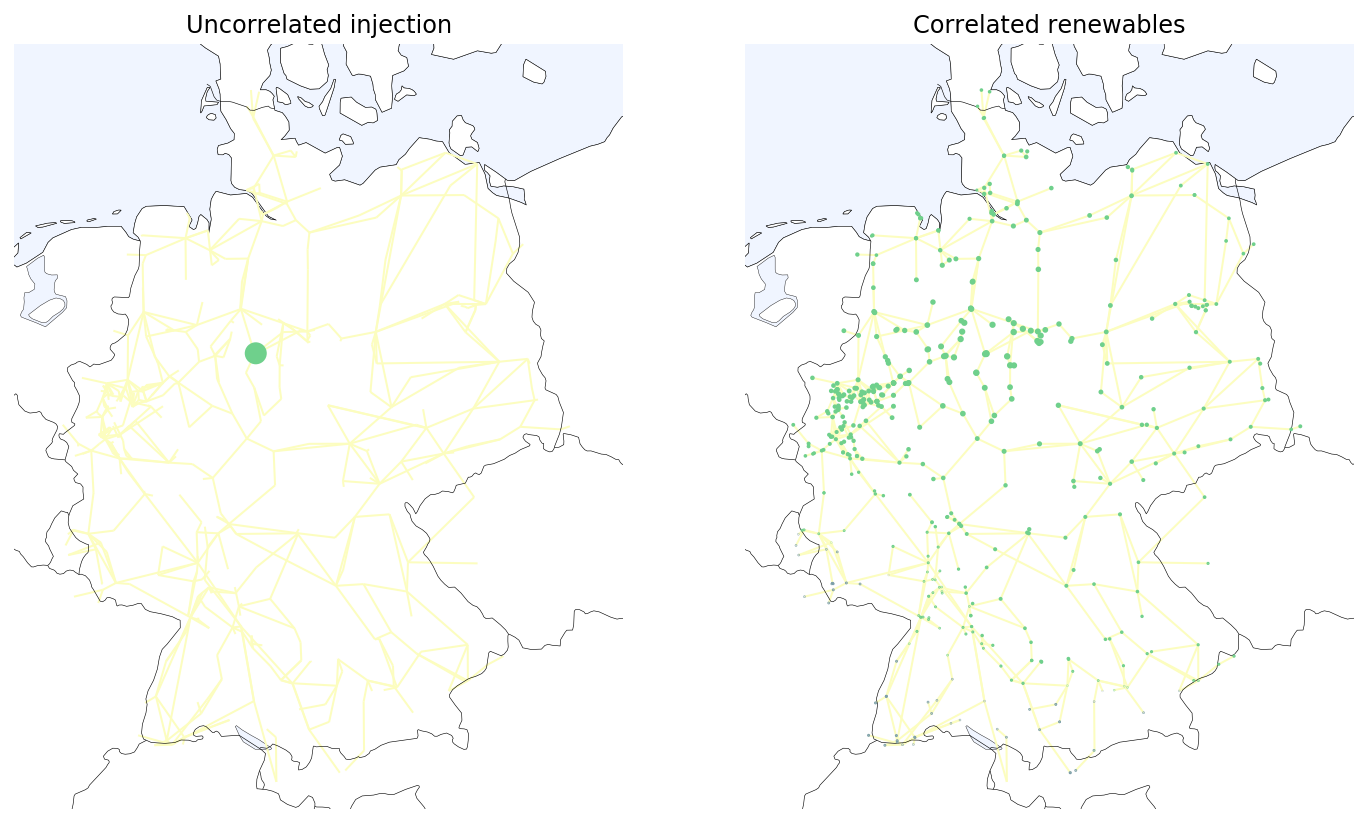

In [80]:
fig = plt.figure(figsize=(12,8))
import cartopy.crs as ccrs 
ax = fig.subplots(1,2,subplot_kw={"projection":ccrs.TransverseMercator(central_longitude=10.0, central_latitude=50.0)}).flatten()

geomap = "50m"

firstBus = 123

# --

sizes = np.zeros(sgn.n)
sizes[firstBus] = 1e-2

line_colors, line_widths = fav_sgn.line_array_to_plot()
bus_sizes, bus_colors = fav_sgn.bus_array_to_plot(sizes * 1e5)

pathcol, linecol = fav_sgn.network.plot(geomap=geomap, bus_sizes=bus_sizes, bus_colors=bus_colors, line_colors=line_colors, line_widths=line_widths, line_cmap="magma_r", ax=ax[0])
#cbar = fig.colorbar(linecol, ax=ax[0], shrink=.5)
#cbar.set_label(f"Covariance with {firstLine}")
ax[0].set_title("Uncorrelated injection")


# --

bus_sizes, bus_colors = fav_sgn.bus_array_to_plot(bus_diff_cov_night_norm[firstBus] * 1e4)

pathcol, linecol = fav_sgn.network.plot(geomap=geomap, bus_sizes=bus_sizes, bus_colors=bus_colors, line_colors=line_colors, line_widths=line_widths, line_cmap="magma_r", ax=ax[1])
ax[1].set_title("Correlated renewables")

# --

for axi in ax:
    src.plothelper.add_water_to_axis(axi, geomap)

#plt.subplots_adjust(wspace=.15)

plt.savefig(f"bus_correlation_{firstBus}_iid_and_fullcov_night.pdf", bbox_inches="tight")

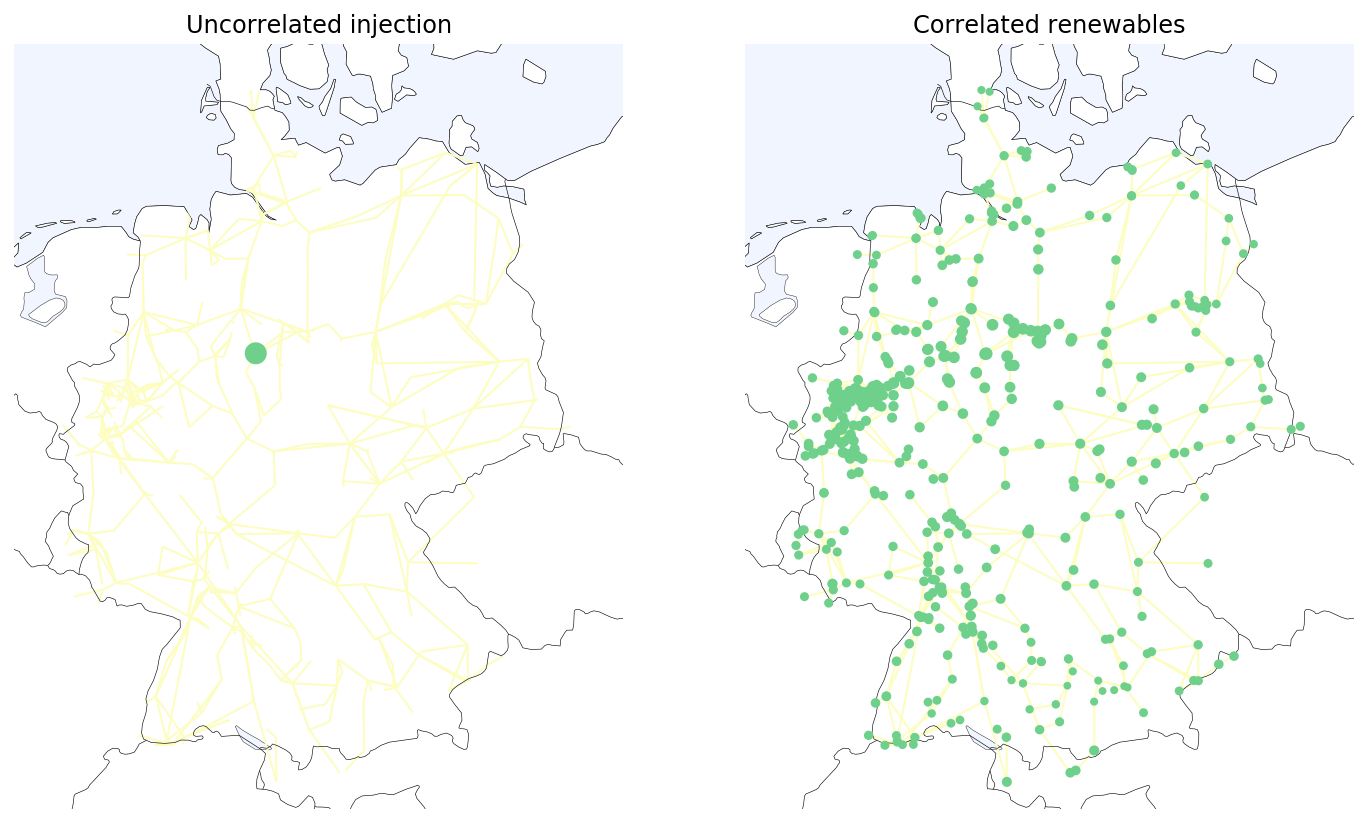

In [81]:
fig = plt.figure(figsize=(12,8))
import cartopy.crs as ccrs 
ax = fig.subplots(1,2,subplot_kw={"projection":ccrs.TransverseMercator(central_longitude=10.0, central_latitude=50.0)}).flatten()

geomap = "50m"

# --

sizes = np.zeros(sgn.n)
sizes[firstBus] = 1e-2

line_colors, line_widths = fav_sgn.line_array_to_plot()
bus_sizes, bus_colors = fav_sgn.bus_array_to_plot(sizes * 1e5)

pathcol, linecol = fav_sgn.network.plot(geomap=geomap, bus_sizes=bus_sizes, bus_colors=bus_colors, line_colors=line_colors, line_widths=line_widths, line_cmap="magma_r", ax=ax[0])
#cbar = fig.colorbar(linecol, ax=ax[0], shrink=.5)
#cbar.set_label(f"Covariance with {firstLine}")
ax[0].set_title("Uncorrelated injection")


# --

bus_sizes, bus_colors = fav_sgn.bus_array_to_plot(bus_diff_cov_day_norm[firstBus] * 1e4)

pathcol, linecol = fav_sgn.network.plot(geomap=geomap, bus_sizes=bus_sizes, bus_colors=bus_colors, line_colors=line_colors, line_widths=line_widths, line_cmap="magma_r", ax=ax[1])
ax[1].set_title("Correlated renewables")

# --

for axi in ax:
    src.plothelper.add_water_to_axis(axi, geomap)

#plt.subplots_adjust(wspace=.15)

plt.savefig(f"bus_correlation_{firstBus}_iid_and_fullcov_day.pdf", bbox_inches="tight")

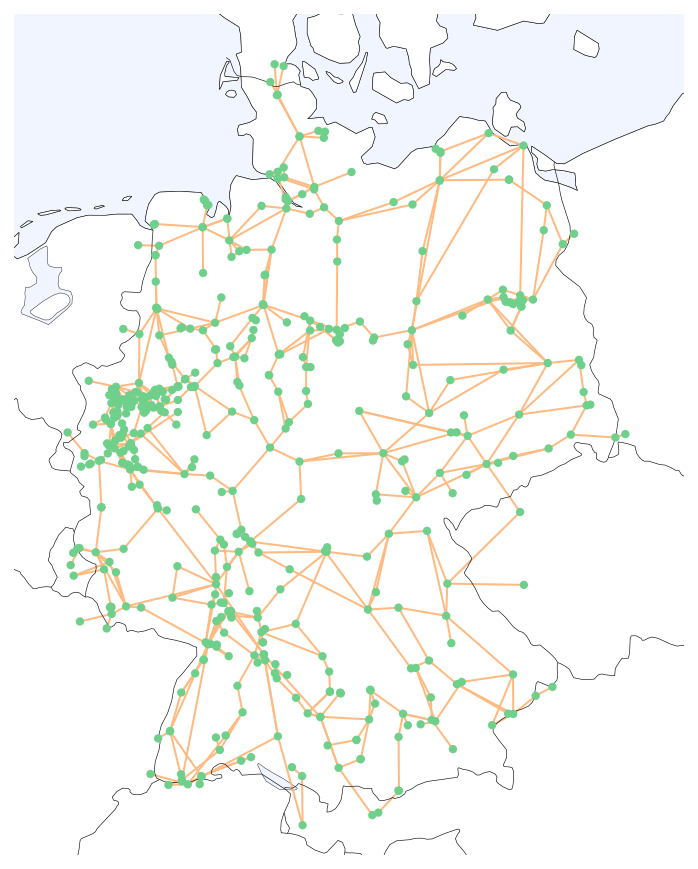

In [101]:
fig = plt.figure(figsize=(6,8))
import cartopy.crs as ccrs 
ax = fig.subplots(1,1,subplot_kw={"projection":ccrs.TransverseMercator(central_longitude=10.0, central_latitude=50.0)})
ax=[ax]
geomap = "50m"

# --

widths = fav_sgn.line_threshold / 1.5e3

line_colors, line_widths = fav_sgn.line_array_to_plot()
bus_sizes, bus_colors = fav_sgn.bus_array_to_plot(np.ones(fav_sgn.m)*1e2)

pathcol, linecol = fav_sgn.network.plot(geomap=geomap, bus_sizes=bus_sizes, bus_colors=bus_colors, line_colors="#FEBA80", line_widths=line_widths, line_cmap="magma_r", ax=ax[0])

for axi in ax:
    src.plothelper.add_water_to_axis(axi, geomap)

#plt.subplots_adjust(wspace=.15)

plt.savefig(f"just_the_network.pdf", bbox_inches="tight")

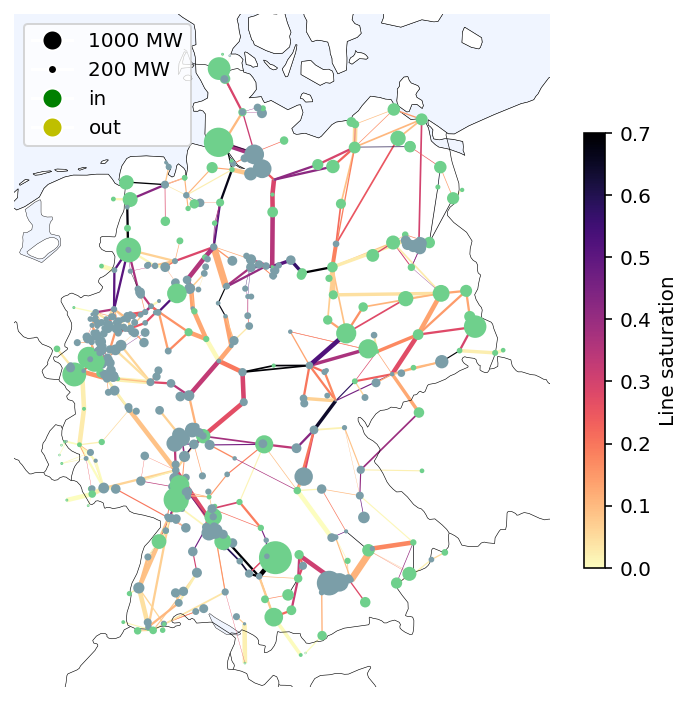

In [96]:
fig = plt.figure(figsize=(6,8))
import cartopy.crs as ccrs 
ax = fig.subplots(1,1,subplot_kw={"projection":ccrs.TransverseMercator(central_longitude=10.0, central_latitude=50.0)})
ax=[ax]
geomap = "50m"

# --

widths = fav_sgn.line_threshold / 1.5e3

line_colors, line_widths = fav_sgn.line_array_to_plot(np.abs(fav_sgn.line_flow_nonlinear.iloc[11] / fav_sgn.line_threshold), widths)
bus_sizes, bus_colors = fav_sgn.bus_array_to_plot(fav_sgn.injection_total.iloc[11])

pathcol, linecol = fav_sgn.network.plot(geomap=geomap, bus_sizes=bus_sizes, bus_colors=bus_colors, line_colors=line_colors, line_widths=line_widths, line_cmap="magma_r", ax=ax[0])
cbar = fig.colorbar(linecol, ax=ax[0], shrink=.5)
cbar.set_label(f"Line saturation")
#ax[0].set_title("Uncorrelated injection")


ax[0].legend(handles=src.plothelper.legend_elements, loc="upper left")

for axi in ax:
    src.plothelper.add_water_to_axis(axi, geomap)

#plt.subplots_adjust(wspace=.15)

plt.savefig(f"nominal_flow_and_injection.pdf", bbox_inches="tight")